# Imbalanced Classification with the Fraudulent Credit Card Transaction Dataset using Python and GridDB


In this tutorial, we will explore the Credit Card Fraud Detection dataset available publicly on Kaggle. It is very crucial for credit card companies to detect fraud to avoid making losses and at the same time, not charging the customers for what they did not actually themselves purchase. We will use GridDB to extract the data, followed by building machine learning models to accurately detect frauds.

The outline of the tutorial is as follows:

 1. Dataset overview
 2. Importing required libraries
 3. Loading the dataset
 4. Exploratory Data Analysis
 5. Machine Learning Model Building
 6. Model Evaluation
 7. Conclusion
 8. References

# GridDB installation

While loading the dataset, this tutorial will cover two methods – Using GridDB as well as Using Pandas. To access GridDB using Python, the following packages also need to be installed beforehand:

1. [GridDB C-client](https://github.com/griddb/c_client)
2. SWIG (Simplified Wrapper and Interface Generator)
3. [GridDB Python Client](https://github.com/griddb/python_client)

# 1. Dataset Overview

The dataset contains all the credit card transactions made by European cardholders on two days in the month of September 2013. There are 284,407 transactions in total out of which 492 are frauds. As evident, the dataset is highly imbalanced, as the fraud class comprises only of 0.172% of all the transactions.

A PCA (Principal Component Analysis) transformation has been applied on the dataset. PCA transformation refers to conversion of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. PCA gives V1, V2, …, V28 as the features and the only features that have not been transformed are Time of the transaction, and Amount of the transaction. Since the rest of the raw (original) features contain confidential information, these are not provided in the final dataset.

Description of the features:

-   Time: It contains the seconds elapsed between each transaction and the first transaction in the dataset.
    
-   Amount: Transaction Amount
    
-   V1, V2, …, V28: Transformed features, hence they might not necessarily be raw features related to credit card transactions.

The dataset is available publicly and can be downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). Please go ahead and download the dataset to follow along this tutorial.

# 2. Importing Required Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

In case you run into a package installation error, you can install it by typing `pip install package-name` in the command line. Alternatively, if you’re using a conda virtual environment, you can type `conda install package-name`.

# 3. Loading the Dataset

Let’s proceed and load the dataset into our notebook.


## 3.a Using GridDB

To store large amounts of data, a CSV file can be cumbersome. GridDB serves as a perfect alternative as it in open-source and a highly scalable database. GridDB is a scalable, in-memory, No SQL database which makes it easier for you to store large amounts of data. If you are new to GridDB, a tutorial on  [reading and writing to GridDB](https://griddb.net/en/blog/using-pandas-dataframes-with-griddb/)  can be useful.

Assuming that you have already set up your database, we will now write the SQL query in python to load our dataset.

In [ ]:
import griddb_python as griddb

sql_statement = ('SELECT * FROM credit_card_dataset')
heart_dataset = pd.read_sql_query(sql_statement, cont)

Note that the `cont` variable has the container information where our data is stored. Replace the `credit_card_dataset` with the name of your container. More info can be found in this tutorial [reading and writing to GridDB](https://griddb.net/en/blog/using-pandas-dataframes-with-griddb/).


## 3.b Using Pandas

We can also use Pandas' `read_csv` function to load our data. Both of the above methods will lead to the same output as the data is loaded in the form of a pandas dataframe using either of the methods.

In [2]:
credit_card_dataset = pd.read_csv('creditcard.csv')

# 4. Exploratory Data Analysis


Once the dataset is loaded, let us now explore the dataset. We'll print the first 10 rows of this dataset using head() function passing in 10 as argument, indicating the number of rows we want to print from the top.

In [3]:
credit_card_dataset.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Here, `Time` is a numeric variable. It doesn't appear that it's going to be useful. We have an `Amount` column containing the transaction amount. Next, we see the distribution of the target variable `Class`. We have 284,315 non-frauds and 492 fraud transaction in the dataset, making it highly imbalanced as only 0.172% transactions are classified as fraud. 

In [4]:
credit_card_dataset.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In order to explore the variable distribution, we can plot them as a histogram. <br>
We'll remove the target variable, and the axis labels so as to de-clutter the plot space.


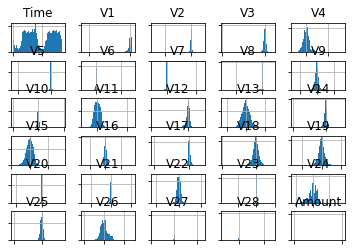

<Figure size 1440x1080 with 0 Axes>

In [5]:
credit_card_dataset_without_target = credit_card_dataset.drop(columns = ['Class'], axis=1)

variable_hist = credit_card_dataset_without_target.hist(bins=100)

for axis in variable_hist.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

plt.figure(figsize = (20,15))
plt.show()

We observe above that the distribution of most of the variables is Gaussian, and a lot of them are centered around zero. This indicates that the variables might have been standardized when they went through the PCA transformation.


# 5. Machine Learning Model Building

Now, let's proceed to building and evaluating machine learning models on our credit card dataset. We'll first create `features` and `labels` for our model and split them into train and test samples. Test size has been kept as 20% of the total dataset size.

In [6]:
features = credit_card_dataset.drop(columns = ['Time', 'Class'], axis = 1)
labels = credit_card_dataset[['Class']]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)

For the purpose of this tutorial, we'll build a **k-Nearest Neighbors** classification model. In k-nearest neigbors technique, for the purpose of prediction, the k-most similar (nearer) points are looked at and accordingly a prediction is made. We keep the `n_neighbors` parameter set as 3.


In [7]:
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train, y_train)

/Users/aniket/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

After the model has been fit on our training data, we can proceed to predicting for our test set in order to evaluate the model performance. Lets store our predictions in `predicted`.

In [8]:
predicted = model.predict(X_test)

# 6. Model Evaluation

We are going to evaluate the model's performance using `classification report` metric. Classification report is a widely used metric to evaluate classification models. It outputs the following:


1. **Precision**: Ratio of correctly predicted positive observations to the total predicted positive observations
2. **Recall**: Ratio of correctly predicted positive observations to the all observations in actual class
3. **F1 score**: Harmonic mean of Precision and Recall
4. **Support**: Number of predicted observations in each class

In [9]:
print(classification_report(predicted,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56882
           1       0.72      0.91      0.81        80

    accuracy                           1.00     56962
   macro avg       0.86      0.96      0.90     56962
weighted avg       1.00      1.00      1.00     56962



# 7. Conclusion

In this tutorial, we saw how can we use GriDB and Python to build a classifier for the Credit Card Fraud Detection Dataset. We examined two ways to import our data, ussing (1) GridDB and (2) Pandas. For large datasets, GridDB provides an excellent alternative to import data in your notebook as it is open-source and highly scalable. [Download GridDB](https://griddb.net/en/downloads/) today!

# 8. References

1. https://www.kaggle.com/mlg-ulb/creditcardfraud
2. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
4. https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/